# Анализ убытков приложения ProcrastinatePRO+

**Цель исследования:** Определить причины убытков развлекательного приложения Procrastinate Pro+ и дать рекомендации по увеличению прибыли, в рамках проведенного анализа.

**Данные для исследования:** Предоставленны данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года, в виде трех датасетов:

1) Лог сервера с данными о посещениях
2) Выгрузка покупок за этот период
3) Рекламные расходы



**Ход исследования:** 
1) Обзор и предобработка данных;

2) Написание функций для расчёта и анализа LTV, ROI, удержания и конверсии; 

3) Исследовательский анализ данных: 
- составлю профили пользователей, 
- определю минимальную и максимальную дату привлечения пользователей; 
- посмотрю из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей; 
- установлю какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи; 
- изучу рекламные источники привлечения и определю каналы, из которых пришло больше всего платящих пользователей. 

4) Анализ маркетинговой деятельности: 
- посчитаю общую сумму расходов на маркетинг; 
- выясню, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник;
- посчитаю CAC из каждого источника. 

5) Анализ окупаемости рекламы. На данном этапе отвечу на вопросы: 
- Окупается ли реклама, направленная на привлечение пользователей в целом?; 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?; 
- Чем могут быть вызваны проблемы окупаемости? 

6) Выводы и рекомендации

### Обзор и предобработка данных

In [1]:
# импортируем библиотеки
import pandas as pd
import numpy as np
from datetime import date, datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
import math
pd.set_option('display.max_columns', None)



In [2]:
# откроем файлы
visits, orders, costs = (
    pd.read_csv('/datasets/visits_info_short.csv'),  # журнал визитов
    pd.read_csv('/datasets/orders_info_short.csv'),  # заказы
    pd.read_csv('/datasets/costs_info_short.csv')  # расходы
)

In [3]:
# посмотрим журнал визитов
visits.head()


,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [4]:
# напишем фунцию для анализа столбцов датафреймов
def df_info(df): 
    count = 0
    df.columns = df.columns.str.lower().str.replace(' ','_') # приведем название столбцов к нижнему регистру
    for column in df.columns:
        count += 1
        print('Название столбца:     ',column)                         
        print('Длина столбца:        ',len(df[column]))           
        print('Количество пропусков: ',df[column].isna().sum())   
        print('Тип данных в столбце: ',df[column].dtype)           
        print(df[column].unique())                        
        print('----------------')
    print('Всего столбцов:', count)                         
    print('Количество дубликатов: ',df.duplicated().sum())        
     

In [5]:
# применим функцию к журналу визитов
df_info(visits)

Название столбца:      user_id
Длина столбца:         309901
Количество пропусков:  0
Тип данных в столбце:  int64
[981449118918 278965908054 590706206550 ... 519022174024 354394066496
 279181973476]
----------------
Название столбца:      region
Длина столбца:         309901
Количество пропусков:  0
Тип данных в столбце:  object
['United States' 'UK' 'France' 'Germany']
----------------
Название столбца:      device
Длина столбца:         309901
Количество пропусков:  0
Тип данных в столбце:  object
['iPhone' 'Mac' 'Android' 'PC']
----------------
Название столбца:      channel
Длина столбца:         309901
Количество пропусков:  0
Тип данных в столбце:  object
['organic' 'TipTop' 'RocketSuperAds' 'YRabbit' 'FaceBoom' 'MediaTornado'
 'AdNonSense' 'LeapBob' 'WahooNetBanner' 'OppleCreativeMedia'
 'lambdaMediaAds']
----------------
Название столбца:      session_start
Длина столбца:         309901
Количество пропусков:  0
Тип данных в столбце:  object
['2019-05-01 02:36:01' '2019-05-01 0

In [6]:
# приведем столбцы со временем к формату datetime
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])


In [7]:
# посмотрим количество уникальных пользователей
visits.value_counts('user_id')

user_id
33606575057     46
943775408561    36
901180916748    35
870784569391    34
86617872511     33
                ..
610429682603     1
236113143735     1
236126190518     1
610402853175     1
497707997464     1
Length: 150008, dtype: int64

In [8]:
# посмотрим общую информацию по заказам
orders.head()


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [9]:
# применим функцию к датафрейму с заказами
df_info(orders)

Название столбца:      user_id
Длина столбца:         40212
Количество пропусков:  0
Тип данных в столбце:  int64
[188246423999 174361394180 529610067795 ... 492983055500 651604369137
 168548862926]
----------------
Название столбца:      event_dt
Длина столбца:         40212
Количество пропусков:  0
Тип данных в столбце:  object
['2019-05-01 23:09:52' '2019-05-01 12:24:04' '2019-05-01 11:34:04' ...
 '2019-10-31 06:17:29' '2019-10-31 22:46:19' '2019-10-31 13:29:06']
----------------
Название столбца:      revenue
Длина столбца:         40212
Количество пропусков:  0
Тип данных в столбце:  float64
[ 4.99  5.99  9.99 49.99 19.99]
----------------
Всего столбцов: 3
Количество дубликатов:  0


In [10]:
# поменяем тип данных в столбце с датой
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

In [11]:
# посмотрим количество уникальных пользователей
orders.value_counts('user_id')

user_id
901180916748    22
883098437811    20
75337957494     19
295795879965    19
512471511263    19
                ..
492528454987     1
491236502836     1
490940924983     1
490703175333     1
999895427370     1
Length: 8881, dtype: int64

In [12]:
# посмотрим общую информацию по заказам
costs.head()

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [13]:
# применим функцию к датафрейму с расходами
df_info(costs)

Название столбца:      dt
Длина столбца:         1800
Количество пропусков:  0
Тип данных в столбце:  object
['2019-05-01' '2019-05-02' '2019-05-03' '2019-05-04' '2019-05-05'
 '2019-05-06' '2019-05-07' '2019-05-08' '2019-05-09' '2019-05-10'
 '2019-05-11' '2019-05-12' '2019-05-13' '2019-05-14' '2019-05-15'
 '2019-05-16' '2019-05-17' '2019-05-18' '2019-05-19' '2019-05-20'
 '2019-05-21' '2019-05-22' '2019-05-23' '2019-05-24' '2019-05-25'
 '2019-05-26' '2019-05-27' '2019-05-28' '2019-05-29' '2019-05-30'
 '2019-05-31' '2019-06-01' '2019-06-02' '2019-06-03' '2019-06-04'
 '2019-06-05' '2019-06-06' '2019-06-07' '2019-06-08' '2019-06-09'
 '2019-06-10' '2019-06-11' '2019-06-12' '2019-06-13' '2019-06-14'
 '2019-06-15' '2019-06-16' '2019-06-17' '2019-06-18' '2019-06-19'
 '2019-06-20' '2019-06-21' '2019-06-22' '2019-06-23' '2019-06-24'
 '2019-06-25' '2019-06-26' '2019-06-27' '2019-06-28' '2019-06-29'
 '2019-06-30' '2019-07-01' '2019-07-02' '2019-07-03' '2019-07-04'
 '2019-07-05' '2019-07-06' '2019-

In [14]:
# поменяем тип данных в столбце с датой
costs['dt'] = pd.to_datetime(costs['dt'])

**Вывод:** \
На данном этапе мы ознакомились с данными о визитах, заказах и рекламных тратах и подготовили данные к анализу.  Дубликатов  и пропусков не обнаружено. Во всех датасетах поменяли тип столбцов с датами или временем на формат datetime.

Уникальных пользователей - 150008. Больше всего один и тот же пользователь появлялся 46 раз. В логах имеются данные о пользователях из 4х стран - США, Англии, Франции, Германии. Среди данных об устройствах представлены iPhone, Android, PC, Mac. Всего записей в датафрейме - 309901.\
В данных о заказах у нас присутствует 8881 уникальный пользователь, самый часто заказывающий пользователь, сделал заказ 22 раза. Всего в выгрузке 40212 строк с информацией о заказах.\
Всего 1800 строк с данными о затратах на маркетинг. В выгрузке представлены данные по закупкам в 10 каналах - 'FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop', 'YRabbit', 'AdNonSense', 'LeapBob', 'OppleCreativeMedia', 'WahooNetBanner', 'lambdaMediaAds' 

### Функции для расчёта и анализа LTV, ROI, удержания и конверсии.



In [15]:
# функция для расчёта удержания
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [16]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [17]:
# функция для расчёта LTV и ROI
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # сохраняем в датафрейм данные пользователей и значения CAC, 
        # добавив параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

Зададим также функции для визуализации этих метрик 

In [18]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [19]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [20]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [21]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

**Вывод:** Заданы основные функции для расчета и визуализации удержания, конверсии, LTV и ROI. 

### Исследовательский анализ данных



#### Построение профилей пользователей и определение минимальной и максимальной даты привлечения пользователей

In [22]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['dt'] = pd.to_datetime(profiles['dt'], format="%Y-%m-%d")
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())


    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    # результаты сохраним в столбец acquisition_cost (CAC)
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [23]:
#используем функцию для создания профилей
profiles = get_profiles(visits, orders, costs)
profiles.head(5)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [24]:
#определим минимальную и максимальную даты привлечения пользователей.
min_analysis_date = profiles['dt'].min()
observation_date = profiles['dt'].max()  
print(' Минимальная дата привелечения пользователей:',min_analysis_date,
      '\n','Максимальная дата привелечения пользователей:',observation_date)

 Минимальная дата привелечения пользователей: 2019-05-01 00:00:00 
 Максимальная дата привелечения пользователей: 2019-10-27 00:00:00


**Вывод:** \
Минимальная дата привлечения пользователей - 1 мая 2019 года. Максимальная дата привлечения пользователей - 27 октября 2019 года. Полученные даты совпадают с датами в описании к таблице, значит все корректно.

#### Определение доли пользователей по странам.

In [25]:
#построим таблицу, отражающую количество пользователей и их долю из каждой страны.
region_share = pd.DataFrame()
region_share['users_cnt'] = profiles.groupby('region')['user_id'].count()
region_share['share'] = ((region_share['users_cnt'] / profiles['region'].count()) * 100)
region_share.sort_values(by='share', ascending=False).style.format({'share': '{:.2f}%'})

,users_cnt,share
region,,
United States,100002,66.66%
UK,17575,11.72%
France,17450,11.63%
Germany,14981,9.99%


In [26]:
#построим таблицу, отражающую долю платящих из каждой страны.
region_payer_share = pd.DataFrame()
region_payer_share['users_cnt'] = profiles.query('payer == True').groupby('region')['user_id'].count()
region_payer_share['share'] = ((region_payer_share['users_cnt'] / profiles.query('payer == True')['region'].count()) * 100)
region_payer_share.sort_values(by='share', ascending=False).style.format({'share': '{:.2f}%'})

,users_cnt,share
region,,
United States,6902,77.72%
UK,700,7.88%
France,663,7.47%
Germany,616,6.94%


In [27]:
#создадим функцию для рассчета доли платящих пользователей 
def pivot_share_result(column, df):
    result = pd.DataFrame()
    result['users_cnt'] = df.groupby(column)['user_id'].count()
    result['users_share'] = ((result['users_cnt'] / df[column].count()) * 100)
    result['payer_users_cnt'] = df.query('payer == True').groupby(column)['user_id'].count()
    result['payer_share'] = ((result['payer_users_cnt'] / result['users_cnt']) * 100)
    return result.sort_values(by='users_share', ascending=False).style.format({'users_share': '{:.2f}%', 'payer_share': '{:.2f}%'})

# расчетаем долю платящих пользователей отдельно по странам.
pivot_share_result('region', profiles)

,users_cnt,users_share,payer_users_cnt,payer_share
region,,,,
United States,100002,66.66%,6902,6.90%
UK,17575,11.72%,700,3.98%
France,17450,11.63%,663,3.80%
Germany,14981,9.99%,616,4.11%


**Вывод:** \
Оснавная доля пользователей из США (66.66%). Далее идут примерно равные доли пользователей из Англии и Франции (~ 12%). Меньше всего пользователей из Германии (~ 10%). \
Аналогичная ситуация по платящим пользователям - из США лидируют (78%), доли платящих из Франции и Англии примерно равны (7-8%), меньше всего платящих пользователей из Германии (~ 7%).\ 
Но общая тенденция такова, что пользователи в основной своей массе не платят. Явно выраженного региона с высокими показателями мы не наблюдаем. 

#### Определение доли  пользователей по устройствам

In [28]:
#определим долю пользоватлей относительно устройства
device_share = pd.DataFrame()
device_share['users_cnt'] = profiles.groupby('device')['user_id'].count()
device_share['share'] = ((device_share['users_cnt'] / profiles['device'].count()) * 100)
device_share.sort_values(by='share', ascending=False).style.format({'share': '{:.2f}%'})

,users_cnt,share
device,,
iPhone,54479,36.32%
Android,35032,23.35%
PC,30455,20.30%
Mac,30042,20.03%


In [29]:
# изучим распределение для платящих пользователей.
device_payer_share = pd.DataFrame()
device_payer_share['users_cnt'] = profiles.query('payer == True').groupby('device')['user_id'].count()
device_payer_share['share'] = ((device_payer_share['users_cnt'] / profiles.query('payer == True')['device'].count()) * 100)
device_payer_share.sort_values(by='share', ascending=False).style.format({'share': '{:.2f}%'})

,users_cnt,share
device,,
iPhone,3382,38.08%
Android,2050,23.08%
Mac,1912,21.53%
PC,1537,17.31%


In [30]:
# рассчитаем долю платящих пользователей отдельно по устройствам.
pivot_share_result('device', profiles)

,users_cnt,users_share,payer_users_cnt,payer_share
device,,,,
iPhone,54479,36.32%,3382,6.21%
Android,35032,23.35%,2050,5.85%
PC,30455,20.30%,1537,5.05%
Mac,30042,20.03%,1912,6.36%


**Вывод:** \
Большинство пользователей - владельцы IPhone (36%) и Android (23%). То есть, клиенты больше пользуются мобильными устройствами, чем ПК. Доли PC и Mac практически одинаковы (20%).\
Ситуация для платящих пользователей повторяет общую картину. Основная доля платящих пользователей - это владельцы IPhone (38%). Далее идут владельцы Android (23%), Mac(21%) и PC(17%).\
В разрезе количества платящих пользователей от общего числа, можно отметить, что лидерство остается за платформой Mac, затем идет iPhone. Пользователи Android и PC занимают последние позиции. 

#### Определение доли пользователей по каналам привлечения

In [31]:
#подсчет общей доли пользователей относительно канала привлечения
channel_share = pd.DataFrame()
channel_share['users_cnt'] = profiles.groupby('channel')['user_id'].count()
channel_share['share'] = ((channel_share['users_cnt'] / profiles['channel'].count()) * 100)
channel_share['payer_users_cnt'] = profiles.query('payer == True').groupby('channel')['user_id'].count()
channel_share['payer_share'] = ((channel_share['payer_users_cnt'] / channel_share['users_cnt']) * 100)
channel_share.sort_values(by='payer_share', ascending=False).style.format({'share': '{:.2f}%', 'payer_share': '{:.2f}%'})

,users_cnt,share,payer_users_cnt,payer_share
channel,,,,
FaceBoom,29144,19.43%,3557,12.20%
AdNonSense,3880,2.59%,440,11.34%
lambdaMediaAds,2149,1.43%,225,10.47%
TipTop,19561,13.04%,1878,9.60%
RocketSuperAds,4448,2.97%,352,7.91%
WahooNetBanner,8553,5.70%,453,5.30%
YRabbit,4312,2.87%,165,3.83%
MediaTornado,4364,2.91%,156,3.57%
LeapBob,8553,5.70%,262,3.06%


**Вывод:** \
Основным источником привлечения пользователей (и платящих, и неплатящих), является органический трафик (~38%) - т.е. клиенты установили приложение сами, без переходов из рекламных баннеров. Далее по числу пользователей идут источники FaceBoom (19%) и TipTop(13%).\
Самый непопулярный канал для всех сегментов пользователей - это lambdaMediaAds(1.43%), для платящих - organic (2.06%)  и OppleCreativeMedia(2.71%).\
Большинство платящих пользователей приходится на каналы FaceBoom (12%), AdNonSense(11%) и lambdaMediaAds(10%)

### Анализ маркетинговой деятельности:



#### Общие затраты на маркетинг

In [32]:
display(costs['costs'].sum())
costs.describe()

105497.30000000002

,costs
count,1800.000000
mean,58.609611
std,107.740223
min,0.800000
25%,6.495000
50%,12.285000
75%,33.600000
max,630.000000


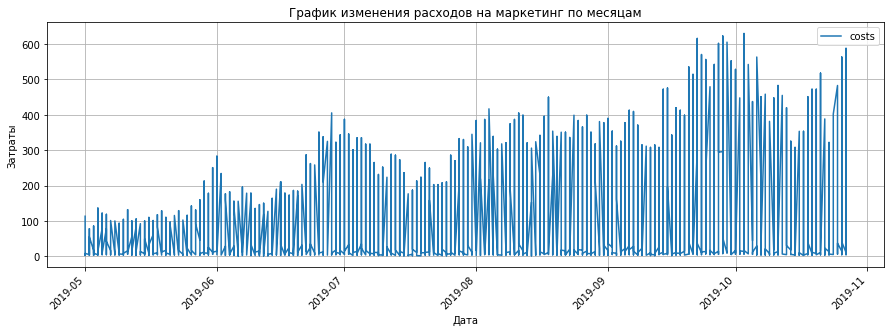

In [33]:
#визуализируем затраты на маркетинг 
costs.plot(x='dt', y='costs', figsize=(15, 5), grid=True, rot=45) 
plt.title('График изменения расходов на маркетинг по месяцам')
plt.xlabel('Дата')
plt.ylabel('Затраты')
plt.show()

На графике видна тенденция увеличения расходов на маркетинг с течением времени. Выделяется период с середины сентября до середины октября, в этот период мы имеем максимальные затраты на маркетинг (630 в начале октября). После чего наблюдается небольшое снижение, а затем снова рост к концу октября. 

In [34]:
#подсчитаем затраты по источникам и визуализируем полученные данные
channel_costs_report =  costs.groupby('channel').agg({'costs': 'sum'}).sort_values(by = 'costs', ascending = False)

display(channel_costs_report)


,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


Text(0, 0.5, 'Затраты')

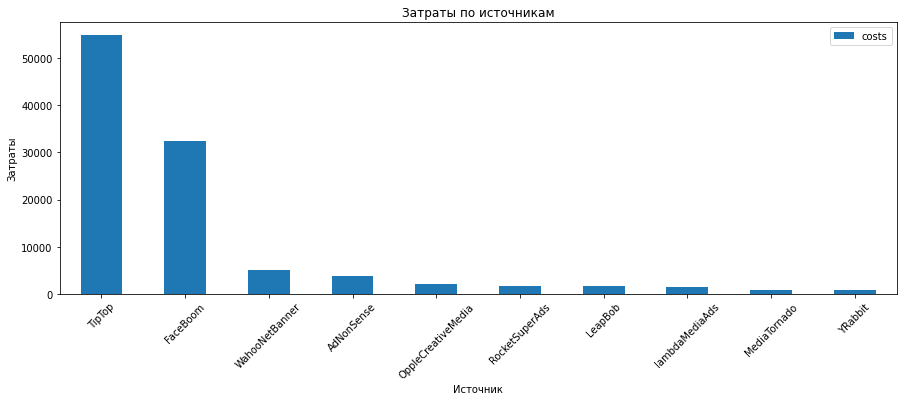

In [35]:
#визуализируем данные
channel_costs_report.plot(kind='bar', figsize=(15,5), rot = 45)
plt.title('Затраты по источникам')
plt.xlabel('Источник')
plt.ylabel('Затраты')

Больше всего затрат приходится на канал TipTop следом идет канал FaceBoom. Меньше всего приходится на MediaTornado и YRabbit

In [36]:
# добавим в таблицу со стоимостью рекламных кампаний месяц и неделю её проведения
costs['month'] = costs['dt'].dt.month
costs['week'] = costs['dt'].dt.isocalendar().week
display(costs)

,dt,channel,costs,month,week
0,2019-05-01,FaceBoom,113.3,5,18
1,2019-05-02,FaceBoom,78.1,5,18
2,2019-05-03,FaceBoom,85.8,5,18
3,2019-05-04,FaceBoom,136.4,5,18
4,2019-05-05,FaceBoom,122.1,5,18
...,...,...,...,...,...
1795,2019-10-23,lambdaMediaAds,4.0,10,43
1796,2019-10-24,lambdaMediaAds,6.4,10,43
1797,2019-10-25,lambdaMediaAds,8.8,10,43
1798,2019-10-26,lambdaMediaAds,8.8,10,43


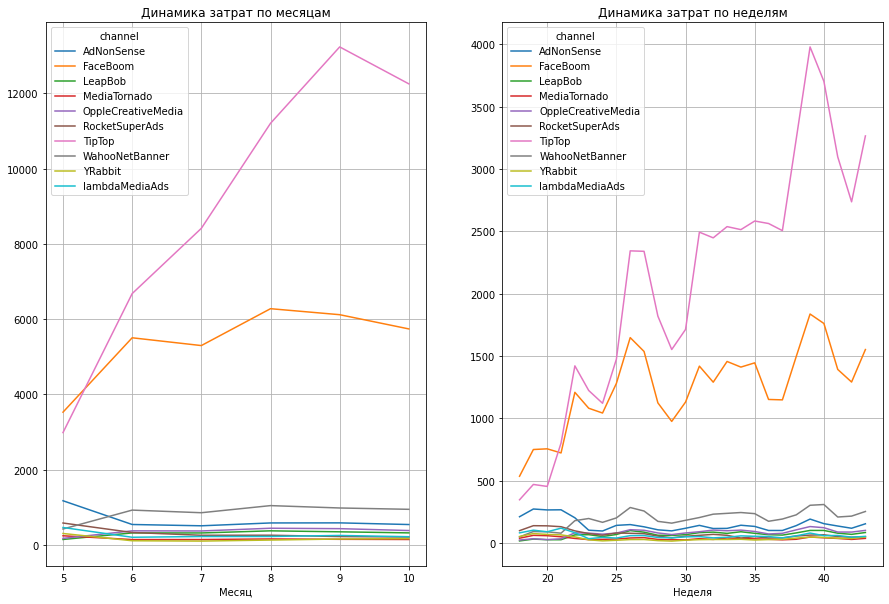

In [37]:
#визуализируем динамику затрат для каждого источника по месяцам и неделям 
ax1 = plt.subplot(1, 2, 1)
filtered_data_m = costs.pivot_table(
        index='month', columns='channel', values='costs', aggfunc='sum'
)
filtered_data_m.plot(grid=True,figsize=(15, 10), ax=ax1)
plt.xlabel('Месяц')
plt.title('Динамика затрат по месяцам')

ax2 = plt.subplot(1,2,2)  
filtered_data_w = costs.pivot_table(
        index='week', columns='channel', values='costs', aggfunc='sum')
filtered_data_w.plot(grid=True,figsize=(15, 10), ax=ax2)
plt.xlabel('Неделя')
plt.title('Динамика затрат по неделям')
    
plt.show() 

Затраты на каналы TipTop и FaceBoom в динамике увеличиваются. По каналу TipTop наблюдается резкий рост к октябрю. Остальные источники не показывают какую-либо значительную динамику.

#### Расчетаем стоимость привлечения нового клиента (CAC)

In [38]:
#удалим пользователей из канала organic, т.к. это помешает дальнейшему анализу
profiles.query('channel != "organic"').describe()

,user_id,acquisition_cost
count,9.356900e+04,93569.000000
mean,4.995116e+11,1.127481
std,2.881600e+11,0.990503
min,5.993260e+05,0.124615
25%,2.506301e+11,0.257143
50%,4.972331e+11,1.080531
75%,7.490889e+11,1.128571
max,9.999799e+11,3.715385


Средняя стоимость привелечения одного пользователя состалвяет 1,12 условных единиц, в то время как медиана составляет 1,08. Это может нам говорить о том, что существуют выбросы с высокой ценой привлечения (это нам показывает максимальное значение - 3,71).

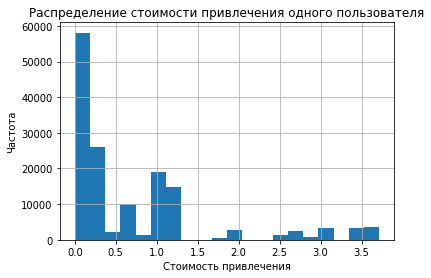

In [39]:
#отобразим частоту стоимости привлечения на графике 
profiles['acquisition_cost'].hist(bins=20)
plt.title('Распределение стоимости привлечения одного пользователя')
plt.xlabel('Стоимость привлечения')
plt.ylabel('Частота')
plt.show()

График показывает нам выбросы, о которых мы говорили (значения больше 1,2), возможно это были разовые рекламные акции. Можно отметить, что в основной своей части стоимость привлечения находится в диапозоне от 0,25 до 1,1.

In [40]:
# Посмотрим на CAC для каждого источника.
cac_by_channel = pd.DataFrame()
cac_by_channel['acquisition_cost_mean'] = profiles.groupby('channel')['acquisition_cost'].mean()
cac_by_channel.sort_values(by='acquisition_cost_mean', ascending=False).style.format({'acquisition_cost_mean': '{:.2f}'})

,acquisition_cost_mean
channel,
TipTop,2.80
FaceBoom,1.11
AdNonSense,1.01
lambdaMediaAds,0.72
WahooNetBanner,0.60
RocketSuperAds,0.41
OppleCreativeMedia,0.25
YRabbit,0.22
MediaTornado,0.22


Самый дорогой канал привлечения - TipTop (средняя стоимость - 2.80 за пользователя), далее идет FaceBoom и AdNonSense примерно в равной ценовой категории (1.11 и 1.01 соответственно). Остальные каналы берут за пользователя от 0.21 до 0.72.

**Вывод:** 

Всего на маркетинг, за изучаемый период, потрачено 105497.3.\
Больше всего трат приходитя на источник TipTop (51.9%). Следом идет источник FaceBoom(30.75%). Далее идут источники WahooNetBanner (4.88%), AdNonSense (3.71%), OppleCreativeMedia (2.04%).\
Средняя стоимость привелечения одного пользователя состалвяет 1,12 условных единиц, в то время как медиана составляет 1,08.  Максимальная стоимость привлечения пользователя - 3.71.



### Анализ окупаемости рекламы



#### Проанализируем общую окупаемость рекламы

In [41]:
#исключим пользователей с органическим трафиком 
profiles = profiles.query('channel != "organic"') 


In [42]:
#зададим горизонт анализа
horizon_days = 14

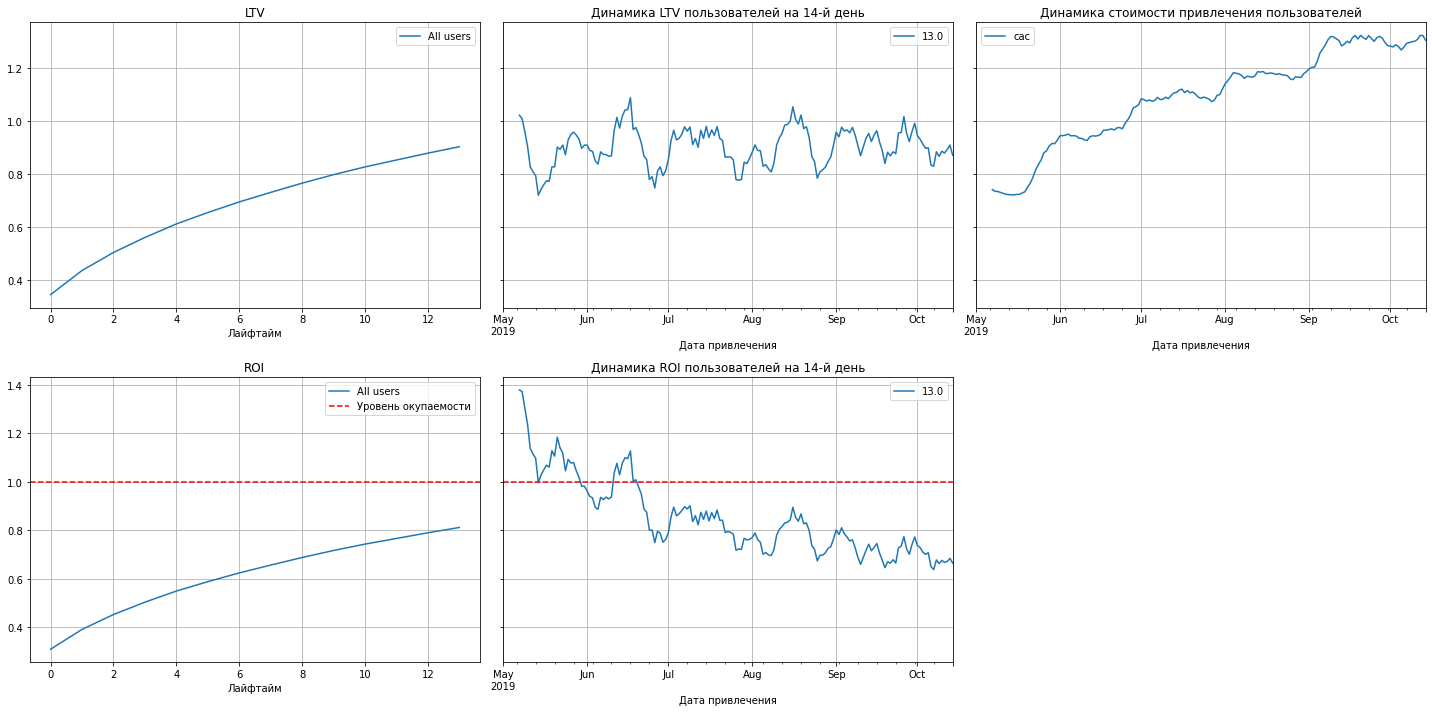

In [43]:
#рассчитаем и визуализируем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Можно выделить следующее:
- CAC (стоимость привеления) на протяжении всего исследуемого периода растет. Рекламный бюджет увеличивается с течением времени;
- К окончанию срока горизонта анализа (2 недели) ROI (окупаемость инвестиций) приближается к отметки окупаемости, но не пересекает ее (достигает лишь 80%). В динамике ROI, начиная с середины июня падает;
- На LTV влияет сезонный фактор, но в целом, этот показатель достаточно стабилен.

Таким образом мы видим, что рекламные компании в текущем виде не окупаются. 


#### Окупаемость рекламы с разбивкой по устройствам

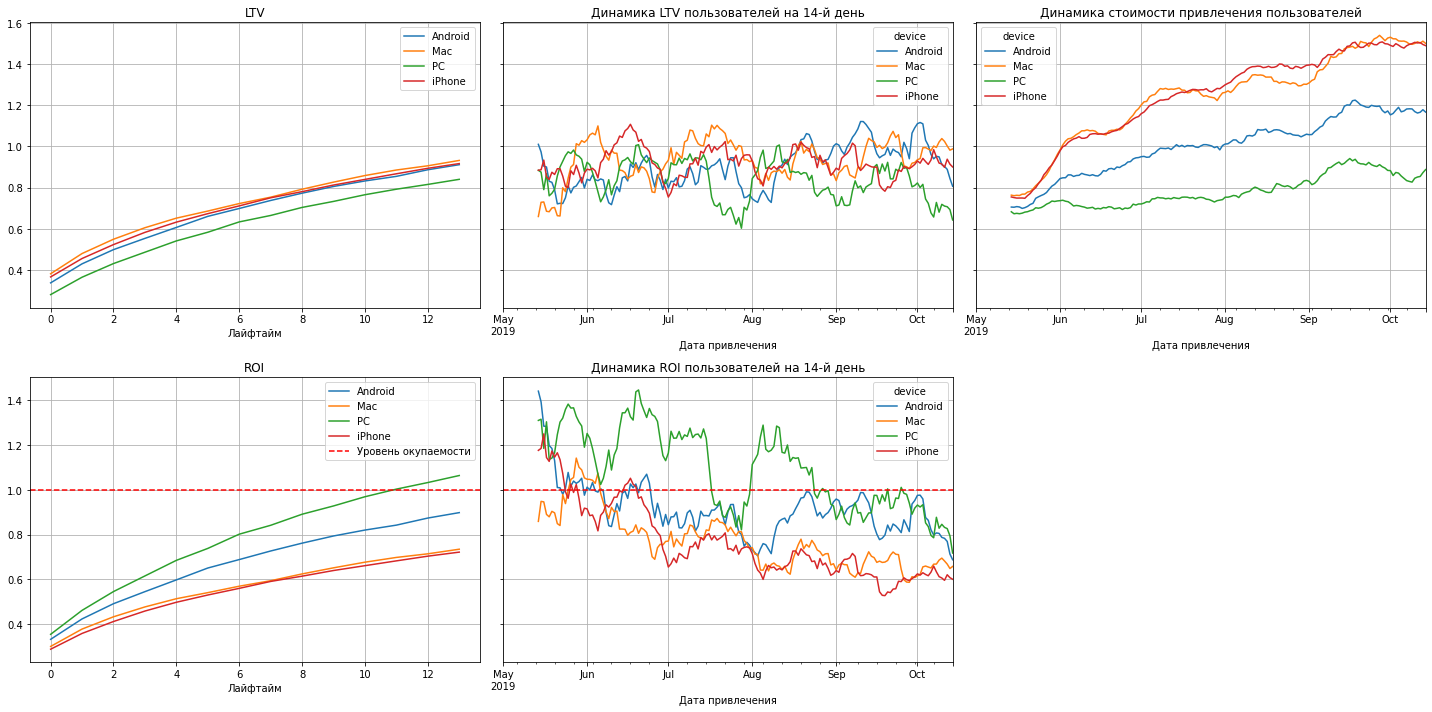

In [44]:
# подсчитаем LTV, CAC и ROI в разрезе устройств и построим графики.
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Выделим следующее:
- Окупились только пользователи PC. Максимально к уровню окупаемости приблизился Android (около 90%), остальные платформы остались на уровне 70% ;
- До июня почти все платформы были выше уровня окупаемости, но затем начинается тенденция к снижению. Платформа Mac к концу мая только достигла порога окупаемости, но в июне также начала снижение. Исключением, является платформа PC, она в большей части времененного промежутка находится выше уровня окупаемости и лишь к концу августа, следуя тенденциям других платформ - начинает падение;
- СAC (стоимость привлечения) в динамике растет у всех платформ. 

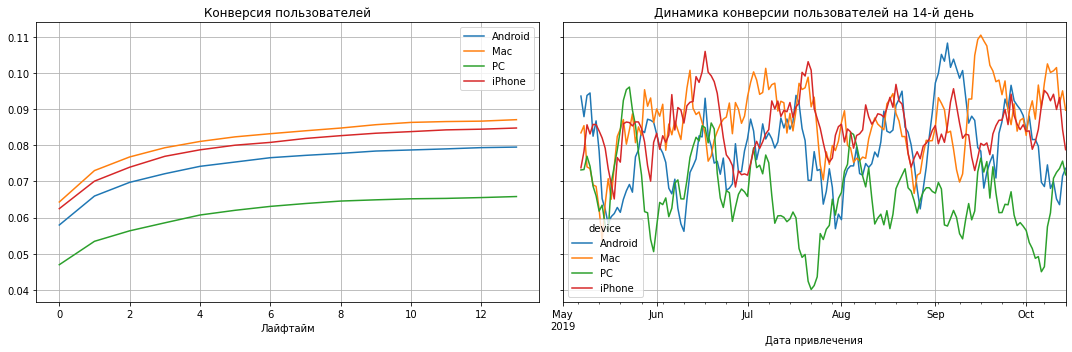

In [45]:
# посмотрим конверсию с разбивкой по устройствам

dimensions = ['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Можно отметить достаточно высокий показатель конверсии у платформ Mac и iPhone, средний у Andorid и небольшой у PC. 

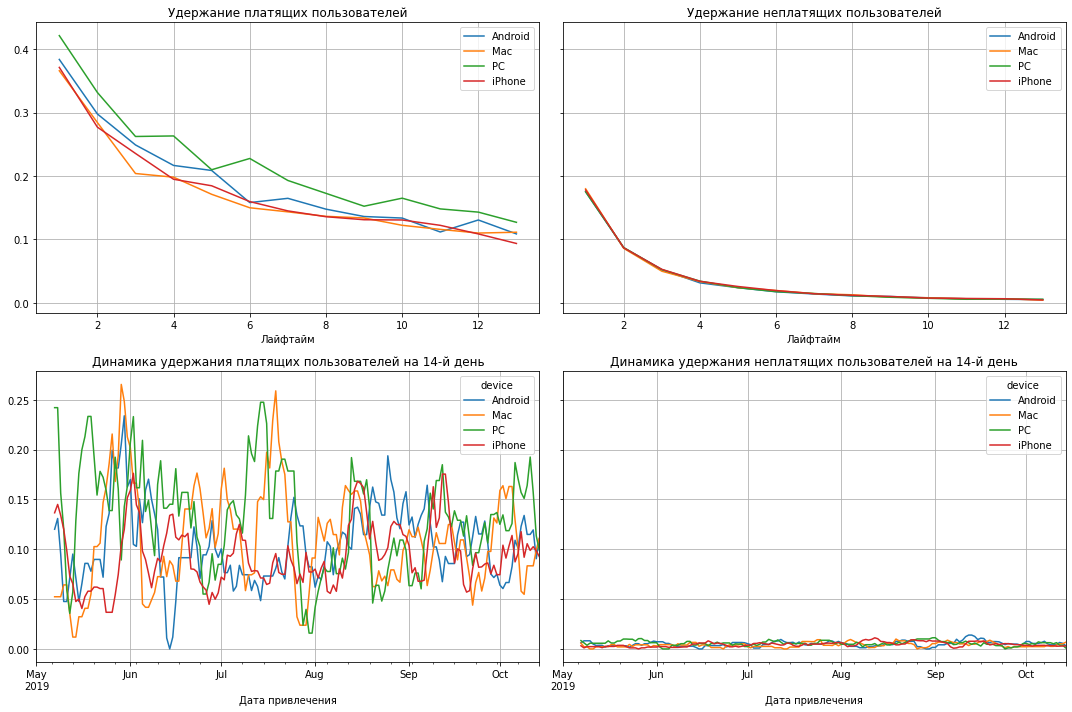

In [46]:
# посмотрим удержание с разбивкой по устройствам
dimensions = ['device']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

- Удержание неплатящих пользователей у всех платформ одинаково - нет никаких всплесков, тенденция к снижению;
- Удержание платящих пользователей тоже имеет тенеденцию к падению. Лучше всего удерживаются пользователи PC, хуже - владельцы iPhone и Mac.

#### Окупаемость рекламы с разбивкой по странам

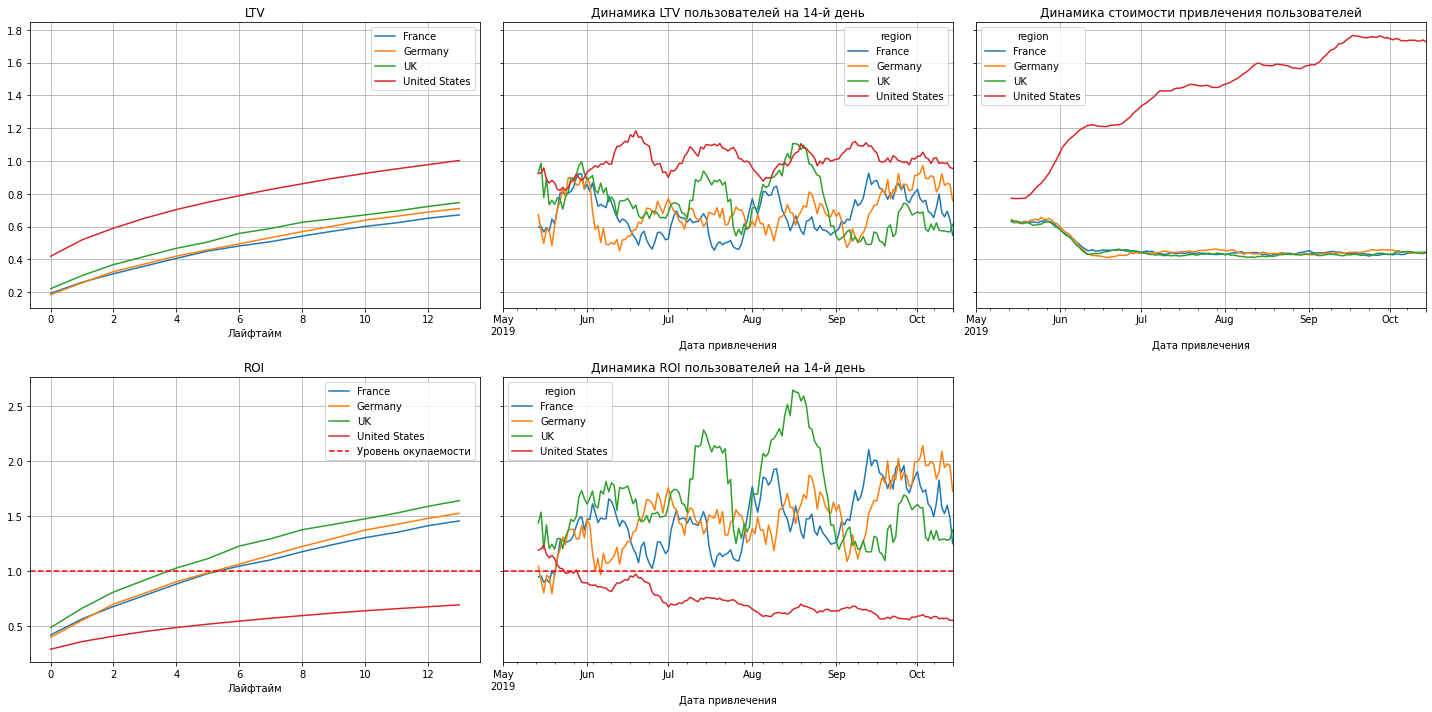

In [47]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Можно выделить следующее:
- В США самый низкий уровень окупаемости рекламы, а стоимость привлечения пользователей самая высокая, при том, что основная аудитория приложения - пользователи из США;
- LTV всё так же подвержен сезонности, но стабилен;
- Лучше всего окупается Англия и Германия.

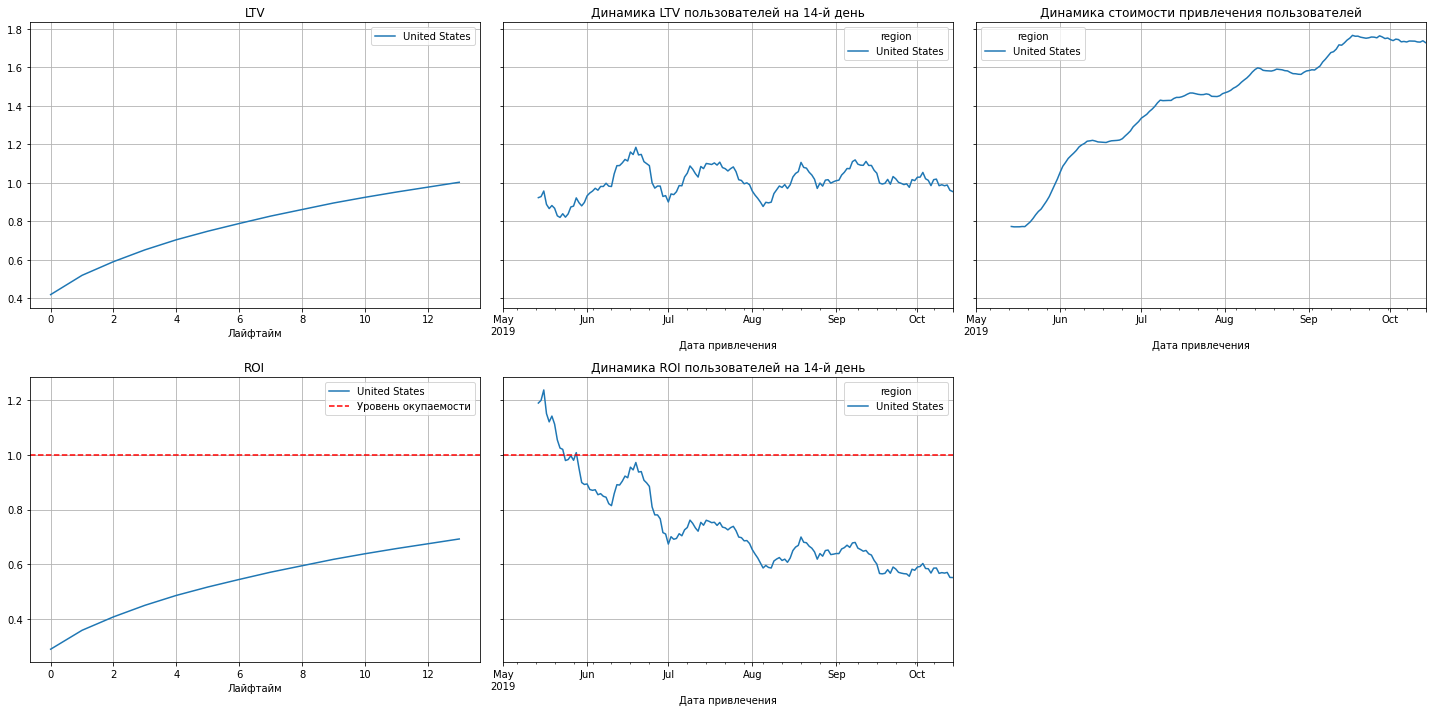

In [48]:
# посмотрим отдельно на динамику окупаемости рекламы в США 
usa_profiles = profiles.query('region == "United States"') 

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    usa_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

ROI за анализируемый период не пересекает уровень окупаемости и приближается только к 70%. В динамике до середины мая показатель был выше границы, после стабильное снижается. Также с середины мая начинается рост стоимости привлечения пользователей.

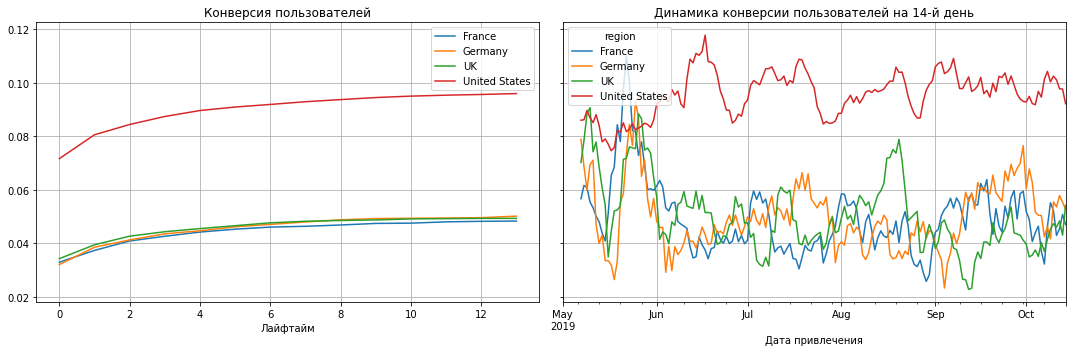

In [49]:
# посмотрим конверсию с разбивкой по странам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Можем отметить слабую конверсию пользователей из Европы, на это может повлиять превалирующее количество пользователей из США над пользователями из Европы.

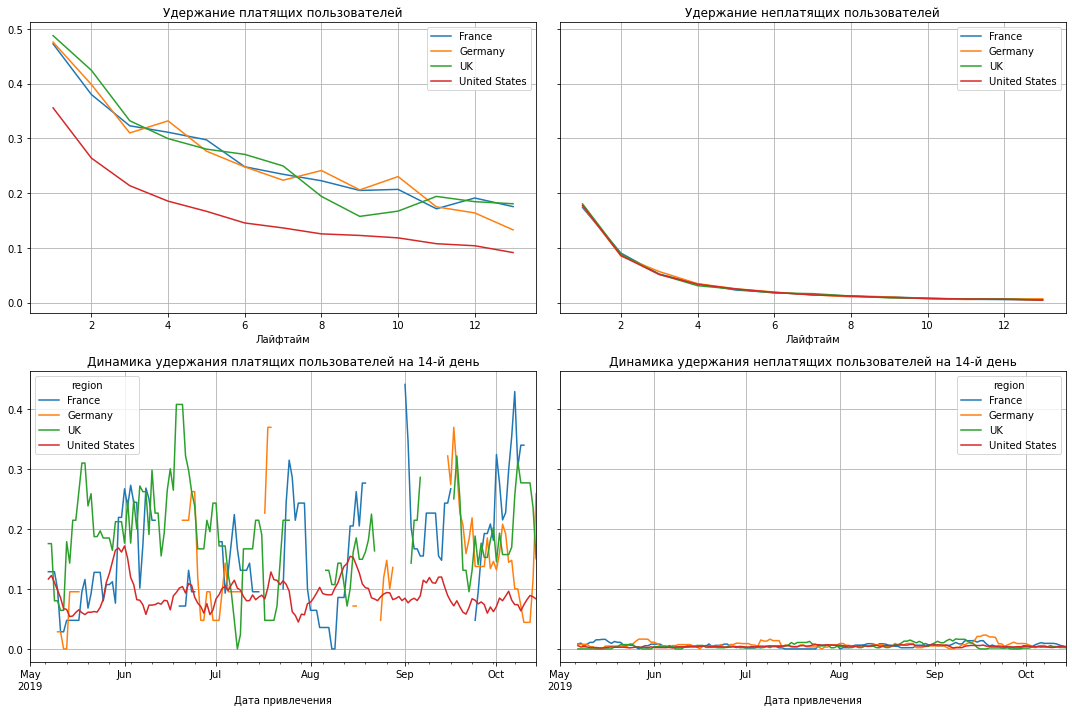

In [50]:
# Смотрим удержание с разбивкой по странам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

- Удержание платящих пользователей США ниже чем пользователей из Европы. В динамике можно заметить прерывающиеся графики, это может свидетельствовать об отсутствии данных в регионах в данном промежутке времени.
- Удержание неплатящих пользователей имеет одинкаовые тенденции к снижению во всех регионах без исключений.

#### Окупаемость рекламы с разбивкой по рекламным каналам

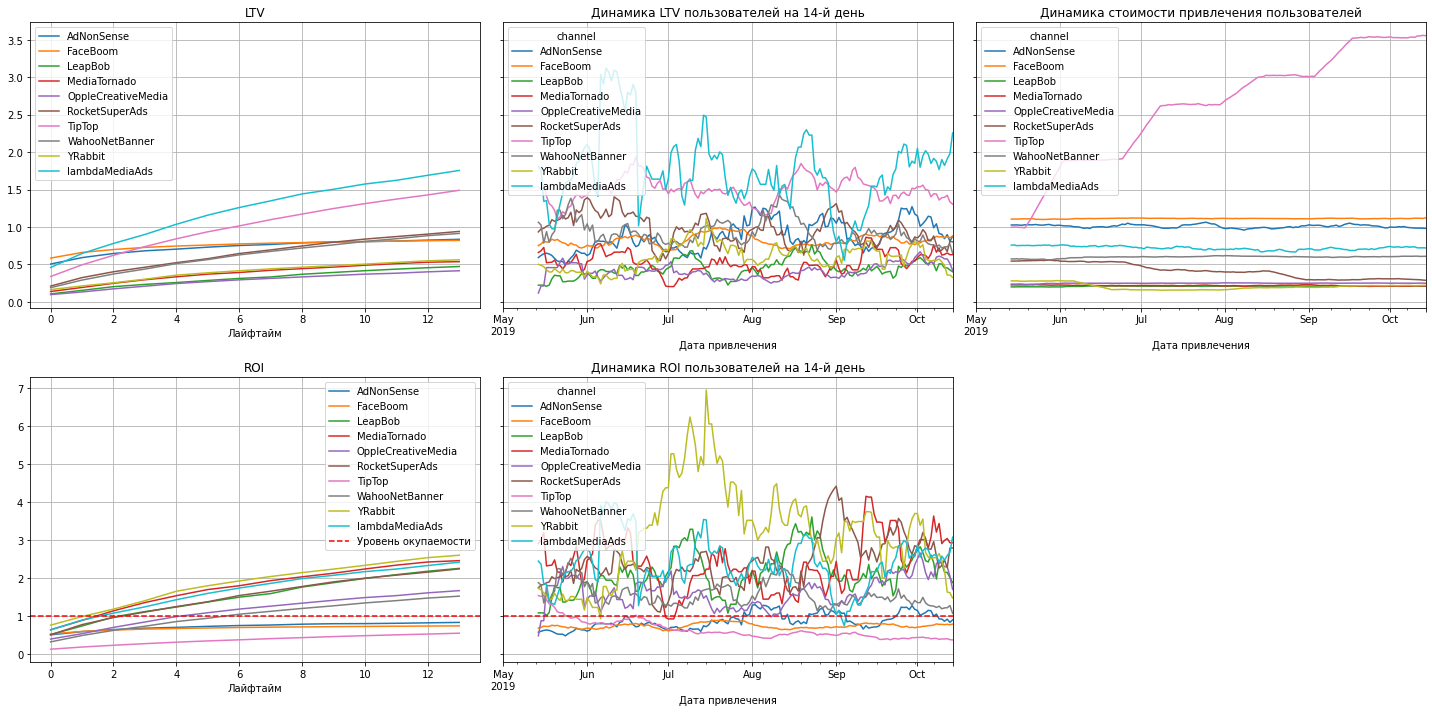

In [51]:
# окупаемость с разбивкой по источникам привлечения

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

- Наблюдается большой рост стоимости привлечения пользователей из рекламного канала TipTop. Достаточно много средств было потрачено на эту рекламную сеть, но реальные результаты ниже ожидаемых;
- Не окупаются пользователи, привлеченные из каналов AdNonSense, FaceBoom, TipTop;
- Лучше показала себя рекламная сеть YRabbit в июле - высокий ROI пользователей на 14 день;


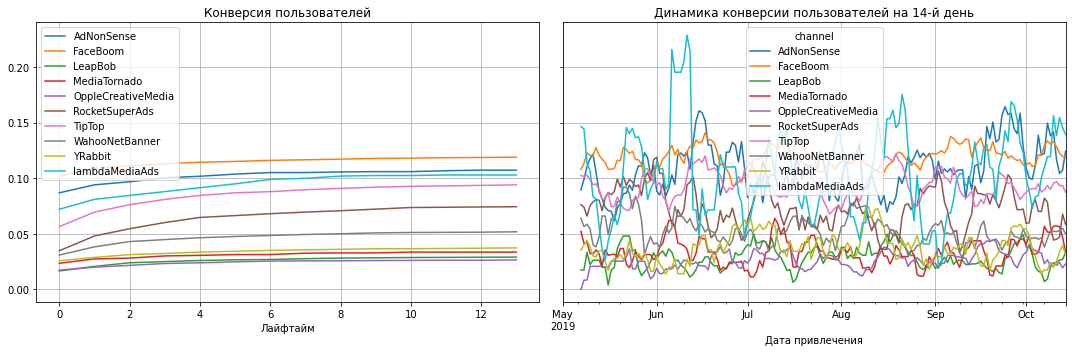

In [52]:
# посмотрим конверсию с разбивкой по каналам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Низкая конверсия пользователей, которые пришли из каналов OppleCreativeMedia, LeapBob, MediaTornado, YRabbit.
Хорошая конверсия с источников FaceBoom, AdNonSense и lambdaMediaAds.

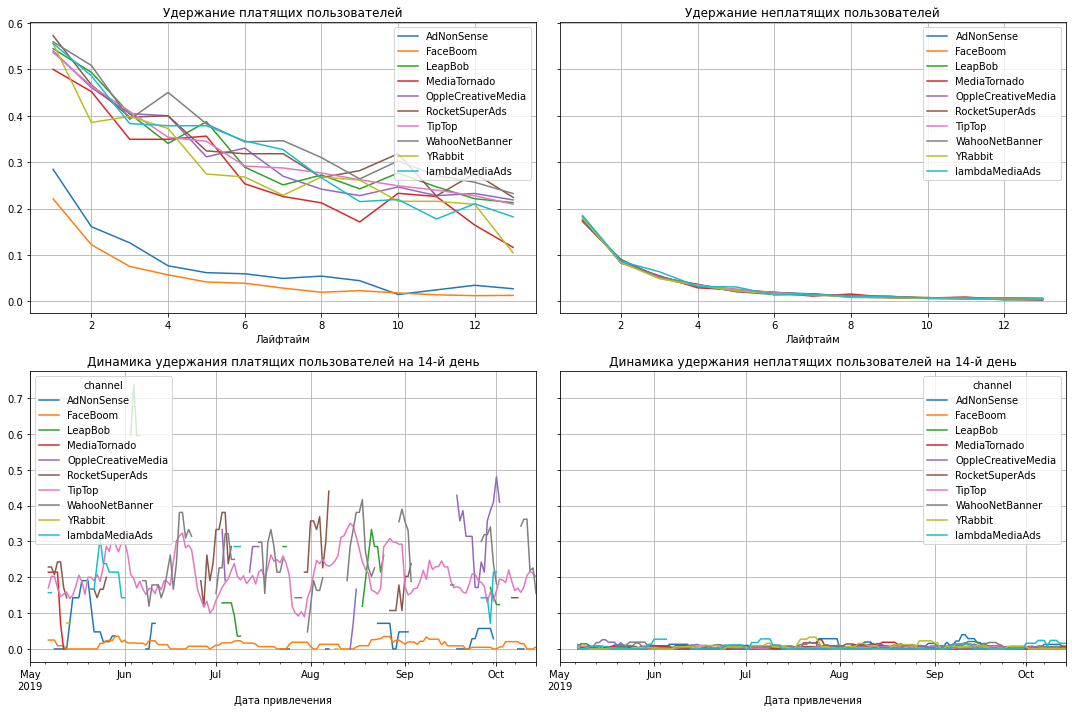

In [53]:
# удержание с разбивкой по каналам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

- Удержание неплатящих пользователей у всех источников одинаково низкое;
- Удержание платящих пользователей - плохо удерживаются пользователи, пришедшие из каналов FaceBoom и AdNonSense. По остальным источникам также снижение. В динамике мы видим прерывистый график, что говорит о фрагментарности данных.

**Вывод:** 
- Реклама не окупается. ROI приближается к точки окупаемости к концу второй недели, но не пересекает ее;
- Факторы негативно влияющие на окупаемость – регион USA, устройства - Mac и iPhone, источники - FaceBoom, TipTop и AdNonSense;
- Проблемы окупаемости могут быть вызваны неравномерным распределением средств на рекламу (в какой-то источник вложено больше средств, чем в остальные, при этом он не оправдал надежд), также возможно, что горизонт анализа недостаточен для того, чтобы пользователи окупились;
- TipTop самый невыгодный канал для привлечения, с которого большинство пользователей из страны USA. 
- Стоит обратить внимание на каналы откуда привлекаются платящие пользователи PC, потому что они удерживаются лучше всего

#### Общий вывод

Всего на маркетинг, за изучаемый период, потрачено 105497.3.\
Больше всего трат приходитя на источник TipTop (51.9%). Следом идет источник FaceBoom(30.75%). Далее идут источники WahooNetBanner (4.88%), AdNonSense (3.71%), OppleCreativeMedia (2.04%).\
Средняя стоимость привелечения одного пользователя состалвяет 1,12 условных единиц, в то время как медиана составляет 1,08.  Максимальная стоимость привлечения пользователя - 3.71.

Рекламные компании в текущем виде не окупаются:
- CAC (стоимость привеления) на протяжении всего исследуемого периода растет. Рекламный бюджет увеличивается с течением времени;
- К окончанию срока горизонта анализа (2 недели) ROI (окупаемость инвестиций) приближается к отметки окупаемости, но не пересекает ее (достигает 80%). В динамике ROI, начиная с середины июня падает;
- На LTV влияет сезонный фактор, но в целом, этот показатель достаточно стабилен.

Были проанализированы характеристики пользователей — страна, канал и устройство первого посещения:

1) Анализ по устройствам:
- Большинство пользователей - владельцы IPhone (36%) и Android (23%). То есть, клиенты больше пользуются мобильными устройствами, чем ПК. Доли PC и Mac практически одинаковы (20%).Ситуация для платящих пользователей повторяет общую картину. Основная доля платящих пользователей - это владельцы IPhone (38%). Далее идут владельцы Android (23%), Mac(21%) и PC(17%).В разрезе количества платящих пользователей от общего числа, можно отметить, что лидерство остается за платформой Mac, затем идет iPhone. Пользователи Android и PC занимают последние позиции;
- Окупились только пользователи PC. Максимально к уровню окупаемости приблизился Android (около 90%), остальные платформы остались на уровне 70%; 
- До июня все платформы были выше уровня окупаемости, но затем начинается тенденция к снижению. Исключением, является платформа PC, она в большей части времененного промежутка находится выше уровня окупаемости и лишь к концу августа, следуя тенденциям других платформ, начинает падение;
- СAC (стоимость привлечения) в динамике растет у всех платформ. 

2) Разбивка по странам:
- Оснавная доля пользователей из США (66.66%). Далее идут примерно равные доли пользователей из Англии и Франции (~ 12%). Меньше всего пользователей из Германии (~ 10%). Аналогичная ситуация по платящим пользователям - из США лидируют (78%), доли платящих из Франции и Англии примерно равны (7-8%), меньше всего платящих пользователей из Германии (~ 7%). Но общая тенденция такова, что пользователи в основной своей массе не платят. Явно выраженного региона с высокими показателями мы не наблюдаем. 
- В США самый низкий уровень окупаемости рекламы, а стоимость привлечения пользователей самая высокая, при том, что основная аудитория приложения - пользователи из США.ROI за анализируемый период не пересекает уровень окупаемости и приближается только к 70%. В динамике до середины мая показатель был выше границы, после стабильное снижается. Также с середины мая начинается рост стоимости привлечения пользователей;
- Лучше всего окупается Англия и Германия.
- Удержание платящих пользователей США ниже чем пользователей из Европы. В динамике можно заметить прерывающиеся графики, это может свидетельствовать об отсутствии данных в регионах в данном промежутке времени. Удержание неплатящих пользователей имеет одинаковые тенденции к снижению во всех регионах без исключений.

3) Разбивка по каналам:
- Основным источником привлечения пользователей (и платящих, и неплатящих), является органический трафик (~38%) - т.е. клиенты установили приложение сами, без переходов из рекламных баннеров. Далее по числу пользователей идут источники FaceBoom (19%) и TipTop(13%);
- Самый непопулярный канал для всех сегментов пользователей - это lambdaMediaAds(1.43%), для платящих - organic (2.06%) и OppleCreativeMedia(2.71%).
- Большинство платящих пользователей приходится на каналы FaceBoom (12%), AdNonSense(11%) и lambdaMediaAds(10%)
- Наблюдается большой рост стоимости привлечения пользователей из рекламного канала TipTop. Достаточно много средств было потрачено на эту рекламную сеть, но реальные результаты ниже ожидаемых;
- Не окупаются пользователи, привлеченные из каналов AdNonSense, FaceBoom, TipTop;
- Лучше показала себя рекламная сеть YRabbit в июле - высокий ROI пользователей на 14 день;



#### Рекомендации

1) Стоит обратить внимание на пользователей РС и Android, так как они лучше окупаются. При том, что стоимость привлечения владельцев Mac и iPhone высока и увеличивается, а окупаемоcть снижается; 
2) Расширить охват европейской аудитории, особенно Англии и Германии. На данный момент там небольшая доля платящих пользователей, но они стабильней окупаются и лучше удерживаются; 
3) Платящие пользователи из США лидируют, но окупаемость данных пользователей начала падать с конца мая 2019 года. Необходимо выяснить, что могло послужить причиной, так как пользователи из США - большая часть аудитории;
4) При росте затрат на каналы TipTop, AdNonSense, FaceBoom и снижении окупаемости, стоит рассмотреть уменьшение бюджета, выделяемого на эти каналы и перенаправление его на более дешевые, но более эффективные каналы - lambdaMediaAds, RocketSuperAds,WahooNetBanner
